In [135]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [136]:
import cv2
from google.colab.patches import cv2_imshow

import numpy as np
import matplotlib.pyplot as plt

In [137]:
targetimg = cv2.imread("drive/MyDrive/PR201910794/img/lab02_people.jpg")
modelimg = cv2.imread("drive/MyDrive/PR201910794/img/lab02_modelpatch.jpg")

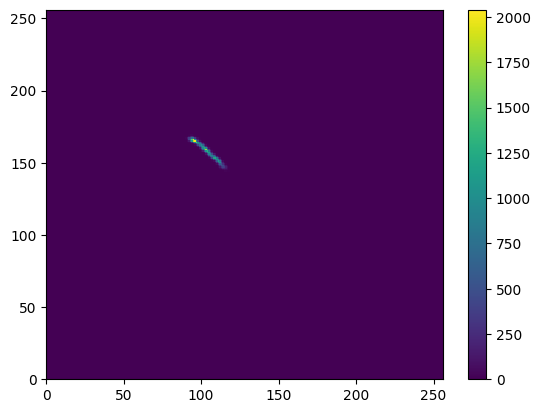

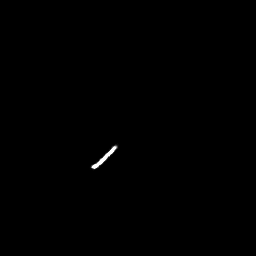

Max value of Model hist before normalize 2041.0
Max value of Target hist before normalize 2041.0
Max value of Model hist 0.008504166666666667
Max value of Target hist 0.04588166666666667


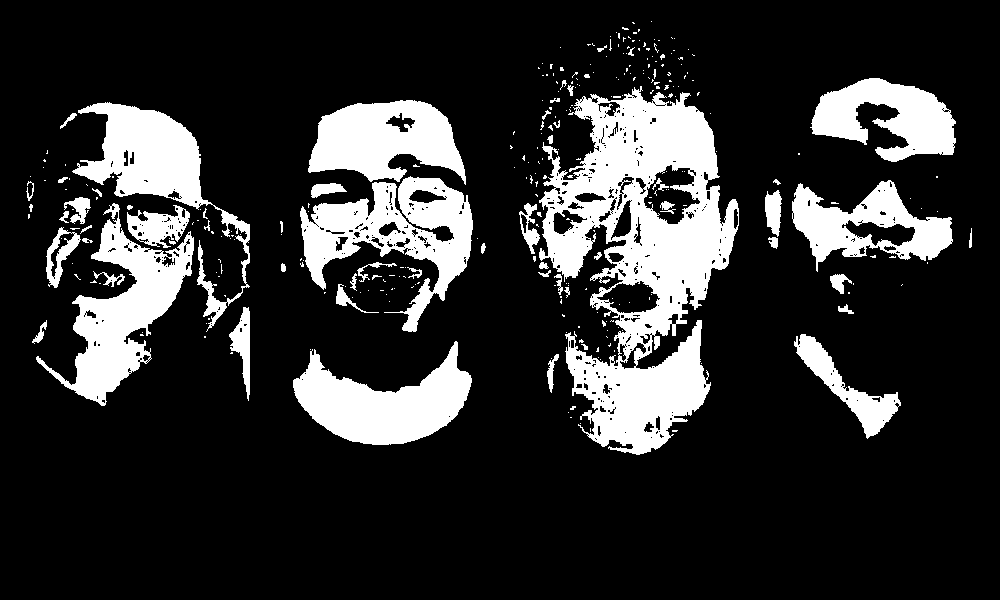

In [138]:
modelimg_ycbcr = cv2.cvtColor(modelimg, cv2.COLOR_BGR2YCrCb)
modelhist_ycbcr = cv2.calcHist([modelimg_ycbcr], [1,2] ,None, [256,256], [0,256,0,256])
plt.pcolor(modelhist_ycbcr)
plt.colorbar()
plt.show()

cv2_imshow(modelhist_ycbcr)
targetimg_ycbcr = cv2.cvtColor(targetimg, cv2.COLOR_BGR2YCrCb)
targethist_ycbcr = cv2.calcHist([targetimg_ycbcr], [1,2], None, [256,256], [0,256,0,256])
## Model과 target 이미지의 histogram 정규화
print("Max value of Model hist before normalize {}".format(modelhist_ycbcr.max()))
print("Max value of Target hist before normalize {}".format(modelhist_ycbcr.max()))

modelhist_ycbcr = modelhist_ycbcr/modelimg.size
targethist_ycbcr = targethist_ycbcr/targetimg.size

## 최대 값이 1보다 작음
print("Max value of Model hist {}".format(modelhist_ycbcr.max()))
print("Max value of Target hist {}".format(targethist_ycbcr.max()))
hist_r = modelhist_ycbcr/ (targethist_ycbcr + 1e-7)
hist_r = np.minimum(hist_r, 1.0)
height, width = targetimg.shape[0], targetimg.shape[1]
output = np.zeros_like(targetimg, dtype='float32')
for i in range(height):
  for j in range(width):
    '''
    비율 히스토그램을 통해
    각 pixel에 대한 confidence 구하기

    '''
    h_val = targetimg_ycbcr[i,j,1]
    s_val = targetimg_ycbcr[i,j,2]
    confidence = hist_r[h_val, s_val]
    output[i,j] = confidence
ret, masked = cv2.threshold(output, 0.02, 255, cv2.THRESH_BINARY)
cv2_imshow(masked)

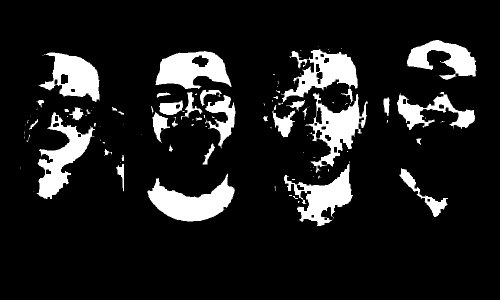

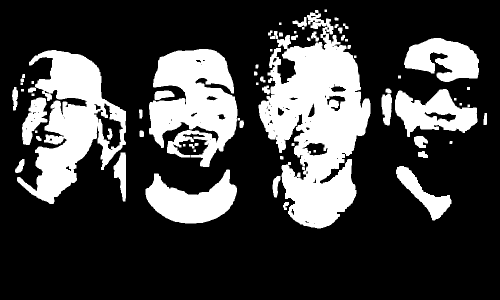

In [139]:
kernel = np.ones((5,5))
morphed_erode = cv2.erode(masked,kernel)
morphed_dilate = cv2.dilate(masked, kernel)

cv2_imshow(cv2.resize(morphed_erode, (500,300)))
cv2_imshow(cv2.resize(morphed_dilate, (500,300)))

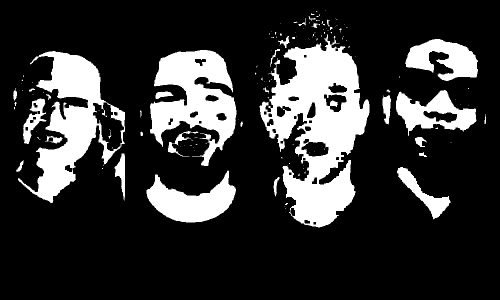

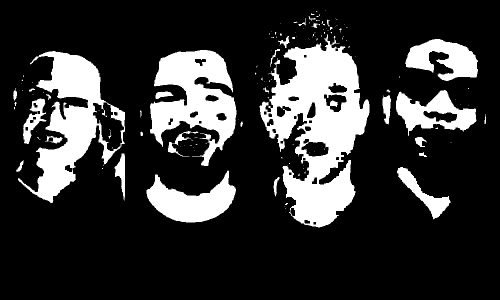

In [140]:
morphed_close = cv2.morphologyEx(masked, cv2.MORPH_CLOSE, kernel)

morphed_dilate = cv2.dilate(masked, kernel)
my_close = cv2.erode(morphed_dilate, kernel)

cv2_imshow(cv2.resize(morphed_close, (500,300)))
cv2_imshow(cv2.resize(my_close, (500,300)))


In [141]:
## 배경 이미지 위에 물체 이미지를 올리는 코드
## background_img : 배경 이미지
## object_img : 물체 이미지
## x_offset : 물체를 위치할 X 좌표 (x 좌측 끝 점)
## y_offset : 물체를 위치할 Y 좌표 (y 위쪽 끝 점)
def insert_img(background_img, object_img, x_offset, y_offset):

  x_end = x_offset + object_img.shape[1]  ## x 우측 끝 점
  y_end = y_offset + object_img.shape[0]  ## y 아래쪽 끝 점

  output_img = np.copy(background_img)    ## 출력 이미지

  for idxy, y in enumerate(range(y_offset,y_end)):
    for idxx, x in enumerate(range(x_offset,x_end)):
      if sum(object_img[idxy, idxx]) == 0:    ## 만약 물체 이미지 값이 검은색일 경우
        output_img[y,x] = background_img[y,x]   ## 배경 이미지 값 넣기
      else:
        output_img[y,x] = object_img[idxy, idxx]    ## 아닐 경우 물체 이미지 값 넣기

  return output_img

In [142]:
dirpath = "drive/MyDrive/PR201910794/img/lab03/"

court1 = cv2.imread(dirpath+"court1.png")
court2 = cv2.imread(dirpath+"court2.png")

playerA_1 = cv2.imread(dirpath+"playerA_1.png")
playerA_2 = cv2.imread(dirpath+"playerA_2.png")
playerA_3 = cv2.imread(dirpath+"playerA_3.png")
playerA_4 = cv2.imread(dirpath+"playerA_4.png")
playerA_5 = cv2.imread(dirpath+"playerA_5.png")

playerB_1 = cv2.imread(dirpath+"playerB_1.png")
playerB_2 = cv2.imread(dirpath+"playerB_2.png")
playerB_3 = cv2.imread(dirpath+"playerB_3.png")
playerB_4 = cv2.imread(dirpath+"playerB_4.png")

referee = cv2.imread(dirpath+"referee.png")


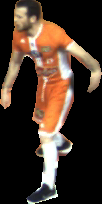

==== AFTER Geometric Transformation ====
[[ 6.1232343e-17 -1.0000000e+00  2.0400000e+02]
 [ 1.0000000e+00  6.1232343e-17 -1.2491398e-14]]


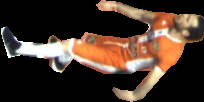

In [143]:
img = playerB_4
cv2_imshow(img)

height = img.shape[0]
width = img.shape[1]
center = (width/2, height/2)
d90 = 90.0 * np.pi / 180

# 동차 행렬을 이용한 기하 변환

M1 = np.array([[np.cos(d90), -1*np.sin(d90), 0],
               [np.sin(d90), np.cos(d90), 0],
               [0, 0, 1]], dtype=np.float32)

M2 = np.array([[1, 0, 0],
               [0, 1, -1*height],
               [0, 0, 1]], dtype=np.float32)


my_M = np.matmul(M1, M2)
my_M = my_M[0:2, :]

print('==== AFTER Geometric Transformation ====')
print(my_M)
playerB_4_rotation = cv2.warpAffine(img, my_M, (height, width))
cv2_imshow(playerB_4_rotation)

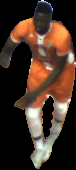

==== AFTER Geometric Transformation ====
[[2. 0. 0.]
 [0. 2. 0.]]


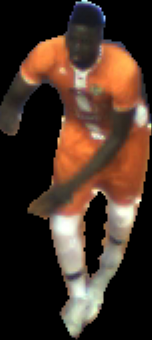

In [144]:
img = playerB_1
cv2_imshow(img)

height = img.shape[0]
width = img.shape[1]
center = (width/2, height/2)


M1 = np.array([[2, 0, 0],
               [0, 2, 0],
               [0, 0, 1]], dtype=np.float32)

M2 = np.array([[1, 0, 0],
               [0, 1, 0],
               [0, 0, 1]], dtype=np.float32)


my_M = np.matmul(M1, M2)
my_M = my_M[0:2, :]

print('==== AFTER Geometric Transformation ====')
print(my_M)
playerB_1_resize = cv2.warpAffine(img, my_M, (2*width, 2*height))
cv2_imshow(playerB_1_resize)

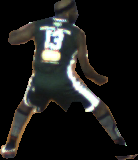

==== AFTER Geometric Transformation ====
[[ -1.   0. 138.]
 [  0.   1.   0.]]


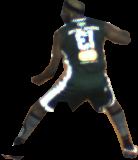

In [145]:
img = playerA_1
cv2_imshow(img)

height = img.shape[0]
width = img.shape[1]
center = (width/2, height/2)


M1 = np.array([[-1, 0, 0],
               [0, 1, 0],
               [0, 0, 1]], dtype=np.float32)

M2 = np.array([[1, 0, -1*width],
               [0, 1, 0],
               [0, 0, 1]], dtype=np.float32)


my_M = np.matmul(M1, M2)
my_M = my_M[0:2, :]

print('==== AFTER Geometric Transformation ====')
print(my_M)
playerA_1_flip = cv2.warpAffine(img, my_M, (width, height))
cv2_imshow(playerA_1_flip)

In [146]:
testinsert = insert_img(court1,playerB_4_rotation, 1000, 700)
testinsert = insert_img(testinsert, playerB_1_resize, 700, 500)
testinsert = insert_img(testinsert, playerA_1_flip, 1000, 800)
cv2_imshow(testinsert)

Output hidden; open in https://colab.research.google.com to view.